In [ ]:
#!curl -sSf https://sshx.io/get | sh -s run

↯ Downloading sshx from https://s3.amazonaws.com/sshx/sshx-x86_64-unknown-linux-musl.tar.gz
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 2971k  100 2971k    0     0  4089k      0 --:--:-- --:--:-- --:--:-- 4093k

↯ Adding sshx binary to /tmp/tmp.RypLfZWtyD

↯ Done! You can now run sshx.

  sshx v0.2.5

  ➜  Link:  https://sshx.io/s/jdJ0sFNUrV#DzwiyyvJte5g9J
  ➜  Shell: /bin/bash



In [ ]:
from google.colab import files

In [ ]:
# Install Kaggle library
!pip install -q kaggle
!mkdir -p ~/.kaggle
# Upload Kaggle API key file (might have to rerun to work)
files.upload()

# Download the dataset
!cp kaggle.json ~/.kaggle/
!kaggle datasets download -d kmader/skin-cancer-mnist-ham10000

# Unzip it
!unzip skin-cancer-mnist-ham10000.zip

Streaming output truncated to the last 5000 lines.
  inflating: ham10000_images_part_2/ISIC_0029325.jpg  
  inflating: ham10000_images_part_2/ISIC_0029326.jpg  
  inflating: ham10000_images_part_2/ISIC_0029327.jpg  
  inflating: ham10000_images_part_2/ISIC_0029328.jpg  
  inflating: ham10000_images_part_2/ISIC_0029329.jpg  
  inflating: ham10000_images_part_2/ISIC_0029330.jpg  
  inflating: ham10000_images_part_2/ISIC_0029331.jpg  
  inflating: ham10000_images_part_2/ISIC_0029332.jpg  
  inflating: ham10000_images_part_2/ISIC_0029333.jpg  
  inflating: ham10000_images_part_2/ISIC_0029334.jpg  
  inflating: ham10000_images_part_2/ISIC_0029335.jpg  
  inflating: ham10000_images_part_2/ISIC_0029336.jpg  
  inflating: ham10000_images_part_2/ISIC_0029337.jpg  
  inflating: ham10000_images_part_2/ISIC_0029338.jpg  
  inflating: ham10000_images_part_2/ISIC_0029339.jpg  
  inflating: ham10000_images_part_2/ISIC_0029340.jpg  
  inflating: ham10000_images_part_2/ISIC_0029341.jpg  
  inflating: h

In [ ]:
import os
import numpy as np
import pandas as pd
from glob import glob
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf
import pickle
import matplotlib.pyplot as plt

In [ ]:
# Set image size and paths
IMG_SIZE = (224, 224)
base_skin_dir = "/content/"
df_meta = pd.read_csv(os.path.join(base_skin_dir, 'HAM10000_metadata.csv'))

# Map images with paths and classes
imageid_path_dict = {
    os.path.splitext(os.path.basename(x))[0]: x
    for x in glob(os.path.join(base_skin_dir, '*', '*.jpg'))
}

lesion_type_dict = {
    'nv': 'Melanocytic nevi', 'mel': 'Melanoma', 'bkl': 'Benign keratosis-like lesions',
    'bcc': 'Basal cell carcinoma', 'akiec': 'Actinic keratoses',
    'vasc': 'Vascular lesions', 'df': 'Dermatofibroma'
}

df_meta['path'] = df_meta['image_id'].map(imageid_path_dict.get)
df_meta['cell_type'] = df_meta['dx'].map(lesion_type_dict.get)
df_meta['cell_type_idx'] = pd.Categorical(df_meta['cell_type']).codes

# Load and preprocess images
def load_and_preprocess_image(path):
    img = load_img(path, target_size=IMG_SIZE)
    img = img_to_array(img) / 255.0  # Normalize to [0, 1]
    return img

X = np.array([load_and_preprocess_image(path) for path in df_meta['path']])
y = df_meta['cell_type_idx'].values


classes = ['df', 'vasc', 'akiec']
df_filtered = df[df['dx'].isin(classes)]

# Train-test split
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)


In [ ]:
# Data generators with augmentation
train_datagen = ImageDataGenerator(
    rotation_range=20, width_shift_range=0.1, height_shift_range=0.1,
    shear_range=0.1, zoom_range=0.1, horizontal_flip=True
)
val_datagen = ImageDataGenerator()

train_generator = train_datagen.flow(X_train, y_train, batch_size=32)
val_generator = val_datagen.flow(X_val, y_val, batch_size=32)


In [ ]:
from tensorflow.keras.applications import VGG19
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau

# Check if a checkpoint exists; if not, load a fresh model
checkpoint_path = "vgg19_skin_cancer_checkpoint.h5"

if os.path.exists(checkpoint_path):
    # Load the model from the previous checkpoint
    print("Loading model from previous checkpoint...")
    model = load_model(checkpoint_path)
else:
    # Initialize new model
    print("No checkpoint found, loading a fresh VGG19 model...")
    base_model = VGG19(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

    # Freeze base model layers
    for layer in base_model.layers:
        layer.trainable = False

    # Build the model
    model = Sequential([
        base_model,
        Flatten(),
        Dense(256, activation='relu'),
        BatchNormalization(),
        Dropout(0.5),
        Dense(7, activation='softmax')
    ])

    # Compile the model
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

model.summary()

# Define checkpoint and learning rate reduction callbacks
checkpoint = ModelCheckpoint(
    checkpoint_path, monitor='val_loss', save_best_only=True, verbose=1
)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-6)


Loading model from previous checkpoint...
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg19 (Functional)          (None, 7, 7, 512)         20024384  
                                                                 
 flatten (Flatten)           (None, 25088)             0         
                                                                 
 dense (Dense)               (None, 256)               6422784   
                                                                 
 batch_normalization (Batch  (None, 256)               1024      
 Normalization)                                                  
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 7)                 1799      
              

In [ ]:
# Load the previous history if it exists
history_file = 'train_history.pkl'

def load_history():
    try:
        with open(history_file, 'rb') as f:
            return pickle.load(f)
    except FileNotFoundError:
        return {'accuracy': [], 'val_accuracy': [], 'loss': [], 'val_loss': []}

# Define training parameters
initial_epoch = len(load_history()['accuracy'])  # Continue from the last saved epoch
total_epochs = 200
epochs_per_session = 40

# Train in increments of 40 epochs, stopping after each session
while initial_epoch < total_epochs:
    print(f"Starting training from epoch {initial_epoch} to {initial_epoch + epochs_per_session}")

    # Train the model for the current session
    history = model.fit(
        train_generator,
        validation_data=val_generator,
        epochs=initial_epoch + epochs_per_session,
        initial_epoch=initial_epoch,
        callbacks=[checkpoint, reduce_lr]
    )

    # Load previous history and save only available keys
    prev_history = load_history()
    for key in history.history:
        if key in prev_history:
            prev_history[key].extend(history.history[key])
        else:
            prev_history[key] = history.history[key]

    with open(history_file, 'wb') as f:
        pickle.dump(prev_history, f)

    # Update initial epoch for the next session
    initial_epoch += epochs_per_session

    print(f"Completed {initial_epoch} epochs. You can now switch to another Colab account and resume training.")


Starting training from epoch 120 to 160
Epoch 121/160
251/251 [==============================] - ETA: 0s - loss: 0.6658 - accuracy: 0.7668
Epoch 121: val_loss improved from inf to 0.71785, saving model to vgg19_skin_cancer_checkpoint.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


251/251 [==============================] - 235s 933ms/step - loss: 0.6658 - accuracy: 0.7668 - val_loss: 0.7179 - val_accuracy: 0.7559 - lr: 1.0000e-06
Epoch 122/160
251/251 [==============================] - ETA: 0s - loss: 0.6635 - accuracy: 0.7655
Epoch 122: val_loss improved from 0.71785 to 0.71745, saving model to vgg19_skin_cancer_checkpoint.h5
251/251 [==============================] - 229s 913ms/step - loss: 0.6635 - accuracy: 0.7655 - val_loss: 0.7175 - val_accuracy: 0.7529 - lr: 1.0000e-06
Epoch 123/160
251/251 [==============================] - ETA: 0s - loss: 0.6651 - accuracy: 0.7636
Epoch 123: val_loss improved from 0.71745 to 0.71682, saving model to vgg19_skin_cancer_checkpoint.h5
251/251 [==============================] - 222s 884ms/step - loss: 0.6651 - accuracy: 0.7636 - val_loss: 0.7168 - val_accuracy: 0.7564 - lr: 1.0000e-06
Epoch 124/160
251/251 [==============================] - ETA: 0s - loss: 0.6766 - accuracy: 0.7627
Epoch 124: val_loss improved from 0.71682 t

KeyboardInterrupt: 

63/63 [==============================] - 43s 676ms/step - loss: 0.7153 - accuracy: 0.7534
Validation Loss: 0.7153, Validation Accuracy: 0.7534


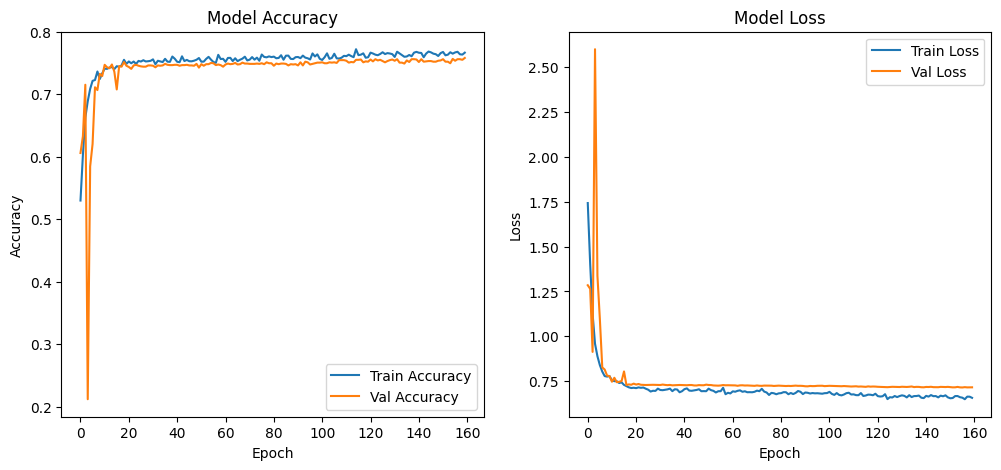

In [ ]:
# Evaluate the model on validation data
val_loss, val_accuracy = model.evaluate(val_generator)
print(f"Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}")

# Plot the final history
with open(history_file, 'rb') as f:
    final_history = pickle.load(f)

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(final_history['accuracy'], label='Train Accuracy')
plt.plot(final_history['val_accuracy'], label='Val Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(final_history['loss'], label='Train Loss')
plt.plot(final_history['val_loss'], label='Val Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()
